In [1]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Custom Dataset

In [3]:
from torchvision import datasets
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image

class CustomDatasetFromImages():
    def __init__(self, csv_path):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.resize = transforms.Resize(224)
        #self.center = transforms.CenterCrop(224)
        self.color = transforms.ColorJitter(0.1, 0.1, 0.1, 0.1)
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # Read the csv file
        self.data_info = pd.read_csv(csv_path)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Third column is for an operation indicator
        self.operation_arr = np.asarray(self.data_info.iloc[:, 2])
        # Calculate len
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        
        # Open image
        img_as_img = Image.open('images/'+str(single_image_name)+'.jpg')

        # Transform image to tensor
        img_resize = self.resize(img_as_img)
        img_color = self.color(img_resize)
        img_as_tensor = self.to_tensor(img_color)
        img_normalized = self.normalize(img_as_tensor)

        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

In [4]:
# Link to CSV
csv_dir = 'csv/control_data.csv'

# Custom dataset
dataset = CustomDatasetFromImages(csv_dir)

## Generate train and validation datasets

In [5]:
validation_split = .2
shuffle_dataset = True
batch_size=32
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)#sampler=train_sampler
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)#, sampler=valid_sampler

## Pull single image with label

tensor(0., dtype=torch.float64)


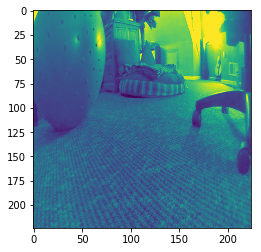

In [6]:
images, labels = next(iter(train_loader))
images = images.numpy()
plt.imshow(images[0][0], interpolation='nearest')
print(labels[0])
plt.show()

## Pytorch Network

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input
        x = x.view(-1, 32 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.25)
)


## Train model & save best

In [8]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in validation_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target.float())
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(validation_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'autopilot.pt')
        valid_loss_min = valid_loss

C:\Users\JoeBa\AppData\Local\conda\conda\envs\mainenv\lib\site-packages\torch\nn\modules\loss.py:443: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([6272, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\JoeBa\AppData\Local\conda\conda\envs\mainenv\lib\site-packages\torch\nn\modules\loss.py:443: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([1568, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 	Training Loss: 0.272818 	Validation Loss: 0.166479
Validation loss decreased (inf --> 0.166479).  Saving model ...
Epoch: 2 	Training Loss: 0.153628 	Validation Loss: 0.144283
Validation loss decreased (0.166479 --> 0.144283).  Saving model ...
Epoch: 3 	Training Loss: 0.143347 	Validation Loss: 0.138945
Validation loss decreased (0.144283 --> 0.138945).  Saving model ...
Epoch: 4 	Training Loss: 0.139660 	Validation Loss: 0.136608
Validation loss decreased (0.138945 --> 0.136608).  Saving model ...
Epoch: 5 	Training Loss: 0.137714 	Validation Loss: 0.135302
Validation loss decreased (0.136608 --> 0.135302).  Saving model ...
Epoch: 6 	Training Loss: 0.136478 	Validation Loss: 0.134361
Validation loss decreased (0.135302 --> 0.134361).  Saving model ...
Epoch: 7 	Training Loss: 0.135503 	Validation Loss: 0.133715
Validation loss decreased (0.134361 --> 0.133715).  Saving model ...
Epoch: 8 	Training Loss: 0.134997 	Validation Loss: 0.133273
Validation loss decreased (0.13371

###  Load the Model with the Lowest Validation Loss

In [9]:
model.load_state_dict(torch.load('autopilot.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Visualize Sample Test Results

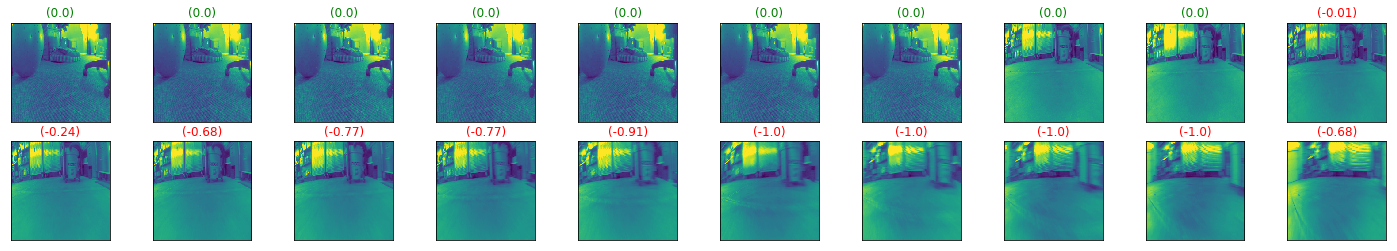

In [10]:
# obtain one batch of test images
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images.cpu()[idx][0])
    ax.set_title("({})".format(labels[idx]), color=("green" if preds[idx]==labels[idx].item() else "red"))


In [14]:
np.argmax(preds)

0

In [ ]:
images[0][0][0]

In [ ]:
print(preds)

In [ ]:
import cv2

In [ ]:
def preprocess(self, camera_value):

    x = camera_value
    x = cv2.resize(x, (224, 224))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x.transpose((2, 0, 1))
    x = torch.from_numpy(x).float()
    x = self.normalize(x)
    x = x.to(self.device)
    x = x[None, ...]

    return x

In [ ]:
im_jpg = '/images/967d64d8-6ba8-11e9-949f-a6029617b541.jpg'

In [ ]:
plt.imshow(images, interpolation='nearest')
print(labels[0])
plt.show()